# KD-LoRA Experimental Results Analysis

## Table I: Performance Comparison Across GLUE Tasks

This notebook analyzes experimental results for the KD-LoRA paper, specifically generating Table I which compares three finetuning strategies (FFT, LoRA with MrLoRA, and KD-LoRA with MrLoRA) across three encoder-only language models (BERT, RoBERTa, DeBERTa-v3) on GLUE benchmark tasks.

**Note:** This analysis focuses on the MrLoRA variant as specified in the paper.


## 1. Setup and Imports

In [1]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Configuration

Define constants for GLUE tasks, model families, and strategies.

In [2]:
# GLUE tasks and their official metrics
GLUE_TASKS = ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'qnli', 'rte', 'wnli']
TASK_METRIC_MAP = {
    'cola': 'eval_matthews_correlation',
    'sst2': 'eval_accuracy',
    'mrpc': 'eval_accuracy',  # MRPC uses accuracy/F1, JSON has accuracy
    'qqp': 'eval_accuracy',   # QQP uses accuracy/F1
    'stsb': 'eval_pearson',   # STS-B uses Pearson correlation
    'mnli': 'matched_accuracy',  # Will handle mismatched separately
    'qnli': 'eval_accuracy',
    'rte': 'eval_accuracy',
    'wnli': 'eval_accuracy'
}

# Model families (encoder-only LLMs)
MODEL_FAMILIES = ['bert', 'roberta', 'deberta']

# Finetuning strategies
STRATEGIES = ['FFT', 'LoRA', 'KD-LoRA']

print("Configuration defined:")
print(f"  GLUE Tasks: {GLUE_TASKS}")
print(f"  Model Families: {MODEL_FAMILIES}")
print(f"  Strategies: {STRATEGIES}")


Configuration defined:
  GLUE Tasks: ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'qnli', 'rte', 'wnli']
  Model Families: ['bert', 'roberta', 'deberta']
  Strategies: ['FFT', 'LoRA', 'KD-LoRA']


## 3. Data Extraction Functions

Define functions to extract and process data from metrics.json files.

In [3]:
def dictor(data, path, default=None):
    """Simple implementation of dictor to access nested dict keys."""
    keys = path.split('.')
    current = data
    for key in keys:
        if isinstance(current, dict) and key in current:
            current = current[key]
        else:
            return default
    return current

def extract_experiment_data(json_file):
    """Extract experiment data from a metrics.json file."""
    variant = json_file.relative_to('results').parts[0]
    
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error reading {json_file}: {e}")
        return []
    
    # Determine strategy based on variant and peft method
    peft_method = dictor(data, 'args.peft', '')
    
    # Map to Table I strategies
    if variant == 'fft':
        strategy = 'FFT'
    elif variant == 'lora' and peft_method == 'mrlora':
        strategy = 'LoRA'
    elif variant == 'kd-lora' and peft_method == 'mrlora':
        strategy = 'KD-LoRA'
    else:
        # Not part of Table I comparison
        return []
    
    # Extract metadata
    model_family = dictor(data, 'args.model_family', '')
    task = dictor(data, 'args.task', '')
    seed = dictor(data, 'args.seed', 0)
    
    # Skip if model_family not in our target list
    if model_family not in MODEL_FAMILIES:
        return []
    
    # Extract metrics
    results = []
    
    # For MNLI, handle matched and mismatched separately
    if task == 'mnli':
        matched_acc = data.get('matched_accuracy')
        mismatched_acc = data.get('mismatched_accuracy')
        
        if matched_acc is not None:
            results.append({
                'Model Family': model_family,
                'Strategy': strategy,
                'Task': 'mnli_m',
                'Metric Value': matched_acc,
                'Metric Name': 'matched_accuracy',
                'Seed': seed,
                'Variant': variant,
                'PEFT Method': peft_method,
                'File': str(json_file)
            })
        
        if mismatched_acc is not None:
            results.append({
                'Model Family': model_family,
                'Strategy': strategy,
                'Task': 'mnli_mm',
                'Metric Value': mismatched_acc,
                'Metric Name': 'mismatched_accuracy',
                'Seed': seed,
                'Variant': variant,
                'PEFT Method': peft_method,
                'File': str(json_file)
            })
    else:
        # For other tasks, find the appropriate metric
        metric_name = TASK_METRIC_MAP.get(task)
        if metric_name and metric_name in data:
            metric_value = data[metric_name]
        else:
            # Fallback: search for any known metric
            for key in ['eval_accuracy', 'eval_matthews_correlation', 'eval_pearson', 'eval_spearman']:
                if key in data:
                    metric_value = data[key]
                    metric_name = key
                    break
            else:
                # No metric found
                return []
        
        results.append({
            'Model Family': model_family,
            'Strategy': strategy,
            'Task': task,
            'Metric Value': metric_value,
            'Metric Name': metric_name,
            'Seed': seed,
            'Variant': variant,
            'PEFT Method': peft_method,
            'File': str(json_file)
        })
    
    return results

print("Data extraction functions defined.")


Data extraction functions defined.


## 4. Data Collection

Collect all relevant data from the results directory.

In [4]:
def collect_all_data(results_dir='results'):
    """Collect all data relevant for Table I."""
    all_records = []
    
    # Find all JSON files
    json_files = list(Path(results_dir).rglob('*.json'))
    print(f"Found {len(json_files)} JSON files total")
    
    for json_file in json_files:
        records = extract_experiment_data(json_file)
        all_records.extend(records)
    
    # Create DataFrame
    df = pd.DataFrame(all_records)
    
    if df.empty:
        print("No data collected!")
        return df
    
    print(f"Collected {len(df)} data records")
    print(f"Unique strategies found: {df['Strategy'].unique().tolist()}")
    print(f"Unique model families found: {df['Model Family'].unique().tolist()}")
    print(f"Unique tasks found: {df['Task'].unique().tolist()}")
    
    return df

# Collect data
raw_df = collect_all_data()

if not raw_df.empty:
    print("\nFirst few rows of raw data:")
    print(raw_df.head())


Found 524 JSON files total
Collected 124 data records
Unique strategies found: ['KD-LoRA', 'FFT', 'LoRA']
Unique model families found: ['bert', 'roberta', 'deberta']
Unique tasks found: ['wnli', 'mrpc', 'rte', 'qnli', 'qqp', 'mnli_m', 'mnli_mm', 'cola', 'sst2', 'stsb']

First few rows of raw data:
  Model Family Strategy  Task  Metric Value    Metric Name  Seed  Variant  \
0         bert  KD-LoRA  wnli        0.5634  eval_accuracy    42  kd-lora   
1      roberta  KD-LoRA  mrpc        0.7328  eval_accuracy    42  kd-lora   
2      roberta  KD-LoRA   rte        0.5487  eval_accuracy    42  kd-lora   
3      roberta  KD-LoRA  wnli        0.3099  eval_accuracy    42  kd-lora   
4      deberta  KD-LoRA  qnli        0.9112  eval_accuracy    42  kd-lora   

  PEFT Method                                               File  
0      mrlora  results/kd-lora/task_wnli_bert_42/base_32_5e-0...  
1      mrlora  results/kd-lora/task_mrpc_roberta_42/base_32_5...  
2      mrlora  results/kd-lora/task_r

## 5. Table I Generation

Create Table I DataFrame with multi-index columns.

In [5]:
def create_table_i_dataframe(raw_df):
    """Create Table I DataFrame with multi-index columns."""
    if raw_df.empty:
        return pd.DataFrame()
    
    # Average metric values across seeds for each combination
    grouped = raw_df.groupby(['Task', 'Model Family', 'Strategy'], as_index=False)
    avg_df = grouped.agg({
        'Metric Value': 'mean',
        'Seed': 'count'
    }).rename(columns={'Seed': 'Num_Seeds'})
    
    # Pivot to create multi-index columns
    pivot_df = avg_df.pivot_table(
        index='Task',
        columns=['Model Family', 'Strategy'],
        values='Metric Value'
    )
    
    # Reorder columns to match desired structure
    column_tuples = []
    for model in MODEL_FAMILIES:
        for strategy in STRATEGIES:
            column_tuples.append((model, strategy))
    
    # Reindex columns to ensure all combinations exist (fill with NaN)
    pivot_df = pivot_df.reindex(columns=pd.MultiIndex.from_tuples(
        column_tuples, names=['Model Family', 'Strategy']
    ))
    
    # Sort rows: GLUE tasks in standard order, then MNLI_m, MNLI_mm
    task_order = GLUE_TASKS.copy()
    task_order.remove('mnli')
    task_order.extend(['mnli_m', 'mnli_mm'])
    
    # Keep only tasks that exist in data
    existing_tasks = [t for t in task_order if t in pivot_df.index]
    pivot_df = pivot_df.loc[existing_tasks]
    
    # Add average row
    avg_row = {}
    for model in MODEL_FAMILIES:
        for strategy in STRATEGIES:
            values = []
            for task in pivot_df.index:
                val = pivot_df.loc[task, (model, strategy)]
                if not pd.isna(val):
                    values.append(val)
            avg_row[(model, strategy)] = np.mean(values) if values else np.nan
    
    avg_df_row = pd.DataFrame([avg_row], index=['Average'], columns=pivot_df.columns)
    pivot_df = pd.concat([pivot_df, avg_df_row])
    
    return pivot_df

# Create Table I
table_df = create_table_i_dataframe(raw_df)

if not table_df.empty:
    print("TABLE I generated successfully!")
    print("\n" + "="*80)
    print("TABLE I: Performance of MrLoRA across GLUE tasks")
    print("Rows: GLUE tasks (including MNLI matched/mismatched)")
    print("Columns: Multi-index (Model Family × Finetuning Strategy)")
    print("Values: Metric scores (accuracy, correlation, etc.)")
    print("="*80 + "\n")
    print(table_df)
    
    # Save to CSV
    csv_path = 'table_i_results.csv'
    table_df.to_csv(csv_path)
    print(f"\nTable saved to {csv_path}")
else:
    print("Failed to create Table I - no data available.")


TABLE I generated successfully!

TABLE I: Performance of MrLoRA across GLUE tasks
Rows: GLUE tasks (including MNLI matched/mismatched)
Columns: Multi-index (Model Family × Finetuning Strategy)
Values: Metric scores (accuracy, correlation, etc.)

Model Family   bert                roberta                deberta         \
Strategy        FFT   LoRA KD-LoRA     FFT   LoRA KD-LoRA     FFT   LoRA   
cola         0.5619    NaN     NaN  0.5929    NaN     NaN  0.6579    NaN   
sst2         0.9197    NaN     NaN  0.9327    NaN     NaN  0.9568    NaN   
mrpc         0.8570 0.8039  0.7181  0.8889 0.8186  0.7328  0.8922 0.7868   
qqp          0.9100 0.8861  0.8754  0.9061 0.8921  0.8791  0.9223 0.9084   
stsb         0.8821 0.8732     NaN  0.9018 0.8716     NaN  0.9131    NaN   
qnli         0.9067 0.9026  0.8691  0.9253 0.9191  0.8865  0.9371 0.9412   
rte          0.6209 0.5921  0.5704  0.6763 0.6426  0.5487  0.7978 0.6318   
wnli         0.4836 0.5775  0.5634  0.5117 0.5634  0.3099  0.5540 0.56

## 6. LaTeX Table Generation

Generate LaTeX code for Table I for paper inclusion.

In [6]:
def generate_latex_table(table_df, caption='Performance of MrLoRA across GLUE tasks'):
    """Generate LaTeX code for Table I."""
    if table_df.empty:
        return ""
    
    # Format values: 4 decimal places, replace NaN with 'N/A'
    formatted_df = table_df.copy()
    for col in formatted_df.columns:
        formatted_df[col] = formatted_df[col].apply(lambda x: f'{x:.4f}' if not pd.isna(x) else 'N/A')
    
    # Build LaTeX
    latex_lines = []
    latex_lines.append('\begin{table}[htbp]')
    latex_lines.append('  \centering')
    latex_lines.append('  \caption{' + caption + '}')
    latex_lines.append('  \label{tab:table_i}')
    latex_lines.append('  \begin{tabular}{l' + 'c' * len(table_df.columns) + '}')
    latex_lines.append('    \toprule')
    
    # Column headers (multi-level)
    col_header1 = 'Task'
    for model in MODEL_FAMILIES:
        col_header1 += ' & \multicolumn{3}{c}{' + model + '}'
    col_header1 += ' \\'
    latex_lines.append('    ' + col_header1)
    
    col_header2 = ''
    for _ in MODEL_FAMILIES:
        for strategy in STRATEGIES:
            col_header2 += ' & ' + strategy
    col_header2 += ' \\'
    latex_lines.append('    ' + col_header2)
    latex_lines.append('    \midrule')
    
    # Data rows
    for idx, row in formatted_df.iterrows():
        row_str = str(idx)
        for model in MODEL_FAMILIES:
            for strategy in STRATEGIES:
                row_str += ' & ' + row[(model, strategy)]
        row_str += ' \\'
        latex_lines.append('    ' + row_str)
    
    latex_lines.append('    \bottomrule')
    latex_lines.append('  \end{tabular}')
    latex_lines.append('\end{table}')
    
    return '\n'.join(latex_lines)

if not table_df.empty:
    latex_table = generate_latex_table(table_df)
    latex_path = 'table_i_latex.tex'
    with open(latex_path, 'w') as f:
        f.write(latex_table)
    print(f"LaTeX table saved to {latex_path}")
    print("\nLaTeX preview (first 10 lines):")
    print('\n'.join(latex_table.split('\n')[:10]))


LaTeX table saved to table_i_latex.tex

LaTeX preview (first 10 lines):
egin{table}[htbp]
  \centering
  \caption{Performance of MrLoRA across GLUE tasks}
  \label{tab:table_i}
 egin{tabular}{lccccccccc}
    	oprule
    Task & \multicolumn{3}{c}{bert} & \multicolumn{3}{c}{roberta} & \multicolumn{3}{c}{deberta} \
     & FFT & LoRA & KD-LoRA & FFT & LoRA & KD-LoRA & FFT & LoRA & KD-LoRA \
    \midrule
    cola & 0.5619 & N/A & N/A & 0.5929 & N/A & N/A & 0.6579 & N/A & N/A \


## 7. Visualizations

Generate visualizations to better understand the results.

Visualization module imported successfully.
Generating visualizations...
Heatmap saved to table_i_heatmap.png
Strategy comparison by model saved to strategy_comparison_by_model.png
Model comparison by task saved to model_comparison_by_task.png
Performance delta plot saved to performance_delta.png
Average performance plot saved to average_performance.png
All visualizations generated!

Generated visualizations:
  - table_i_heatmap.png


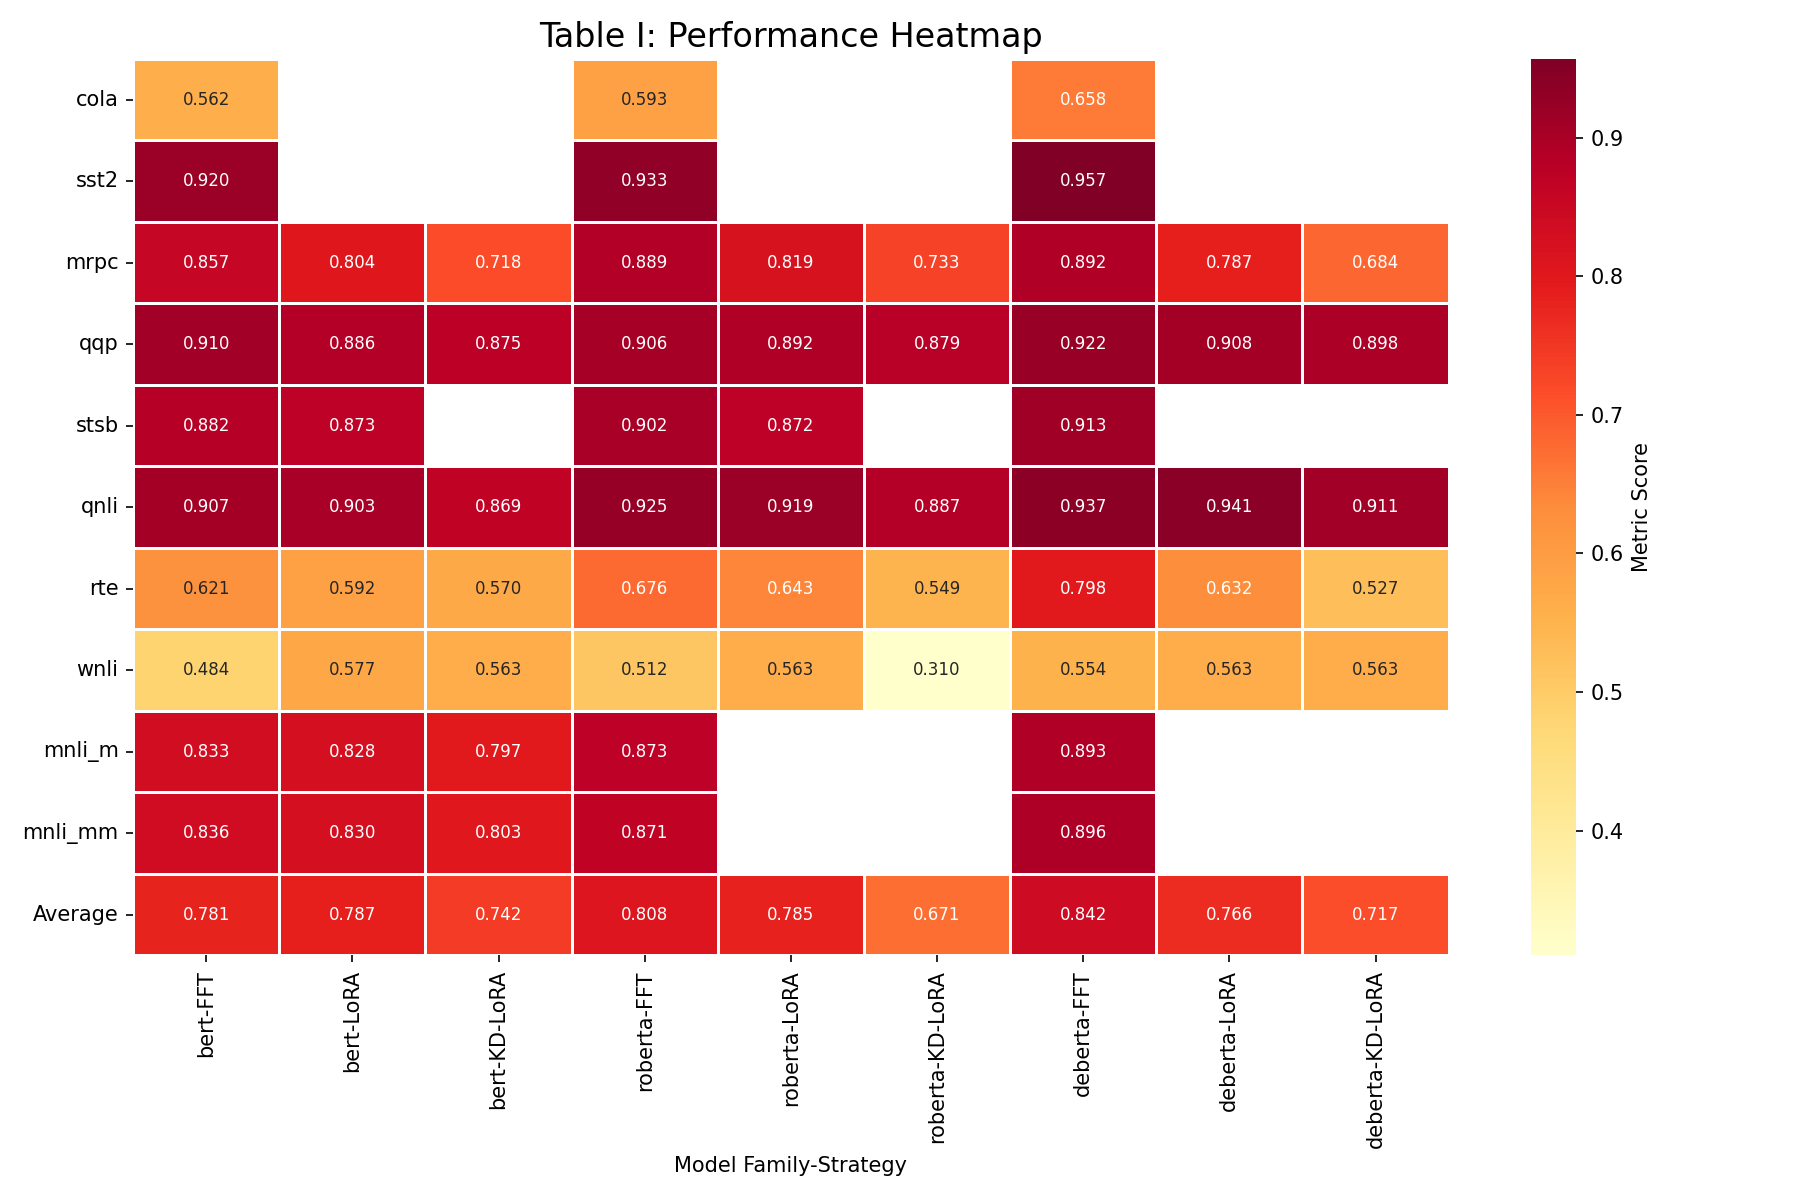

  - strategy_comparison_by_model.png


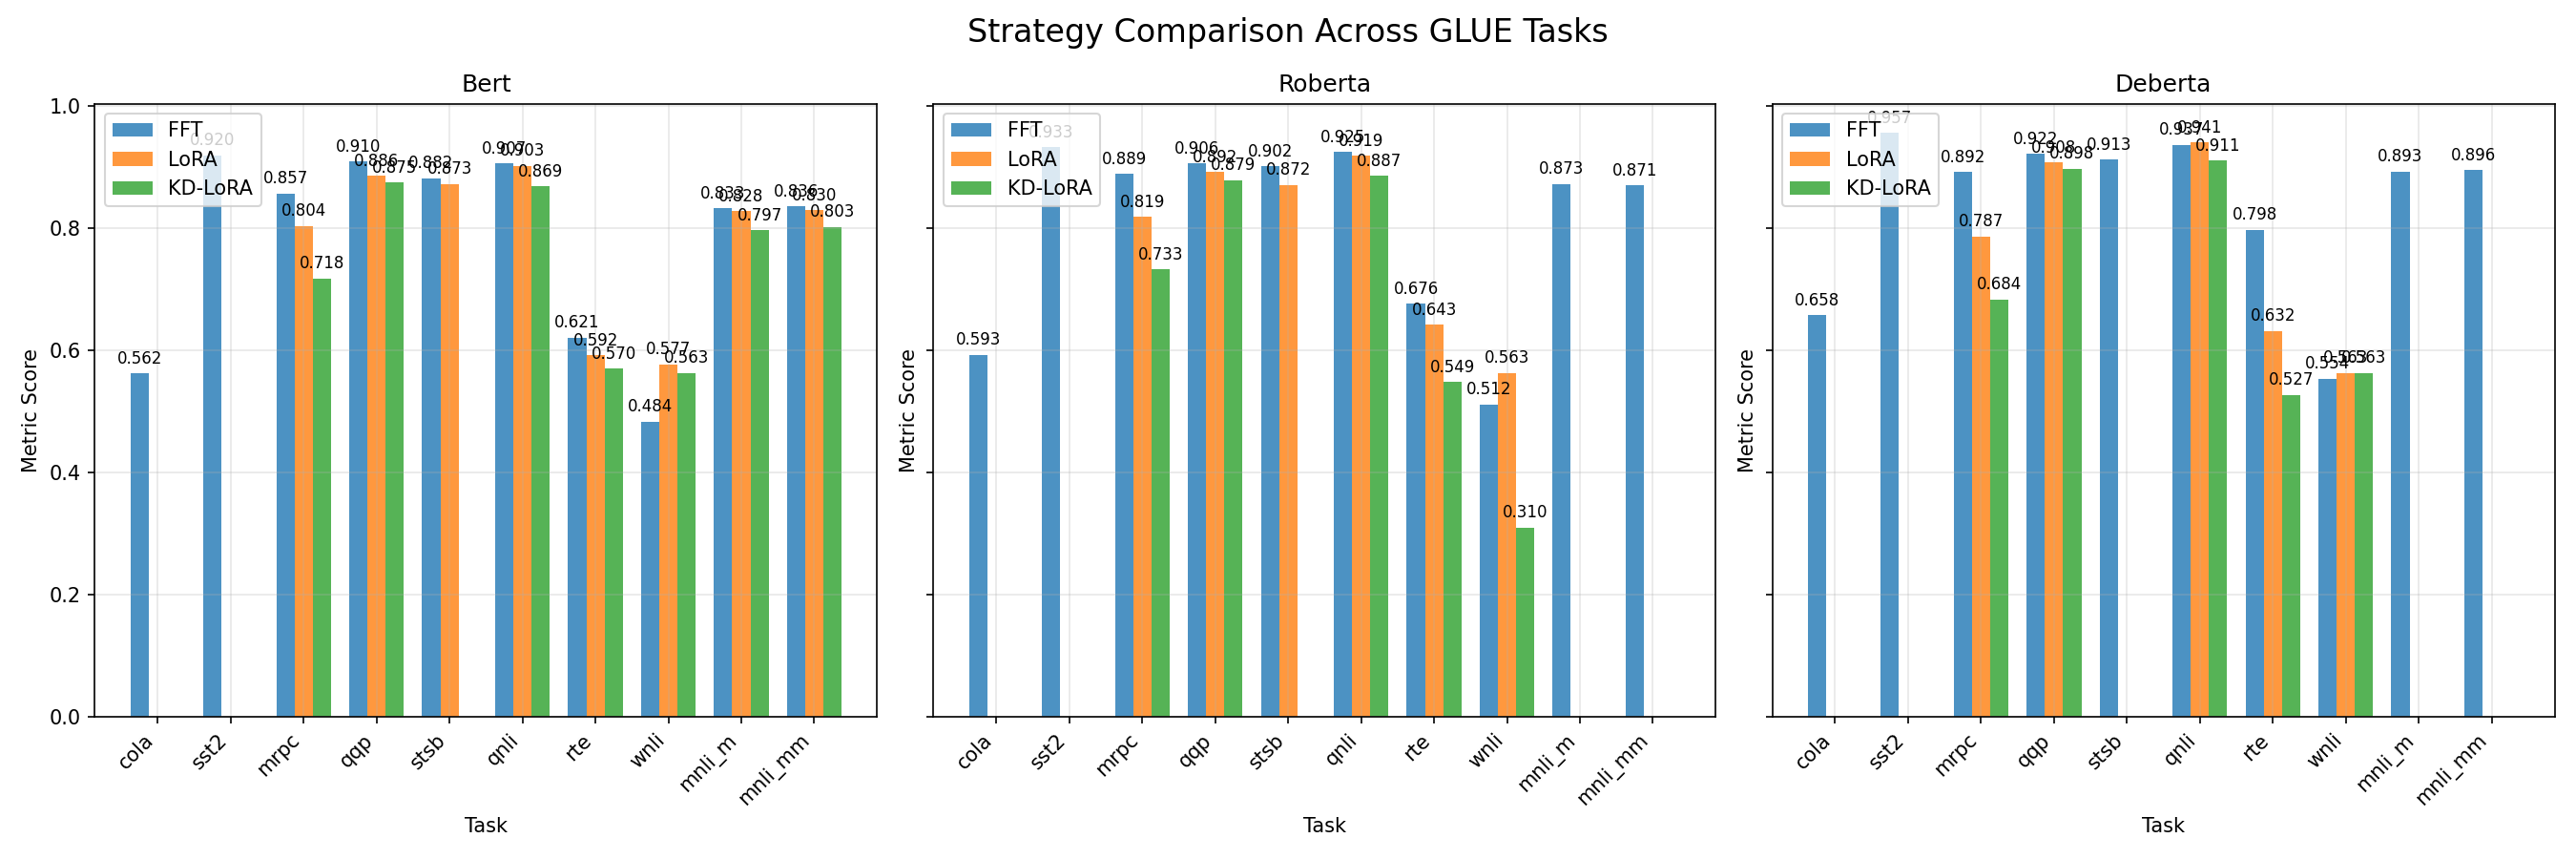

  - model_comparison_by_task.png


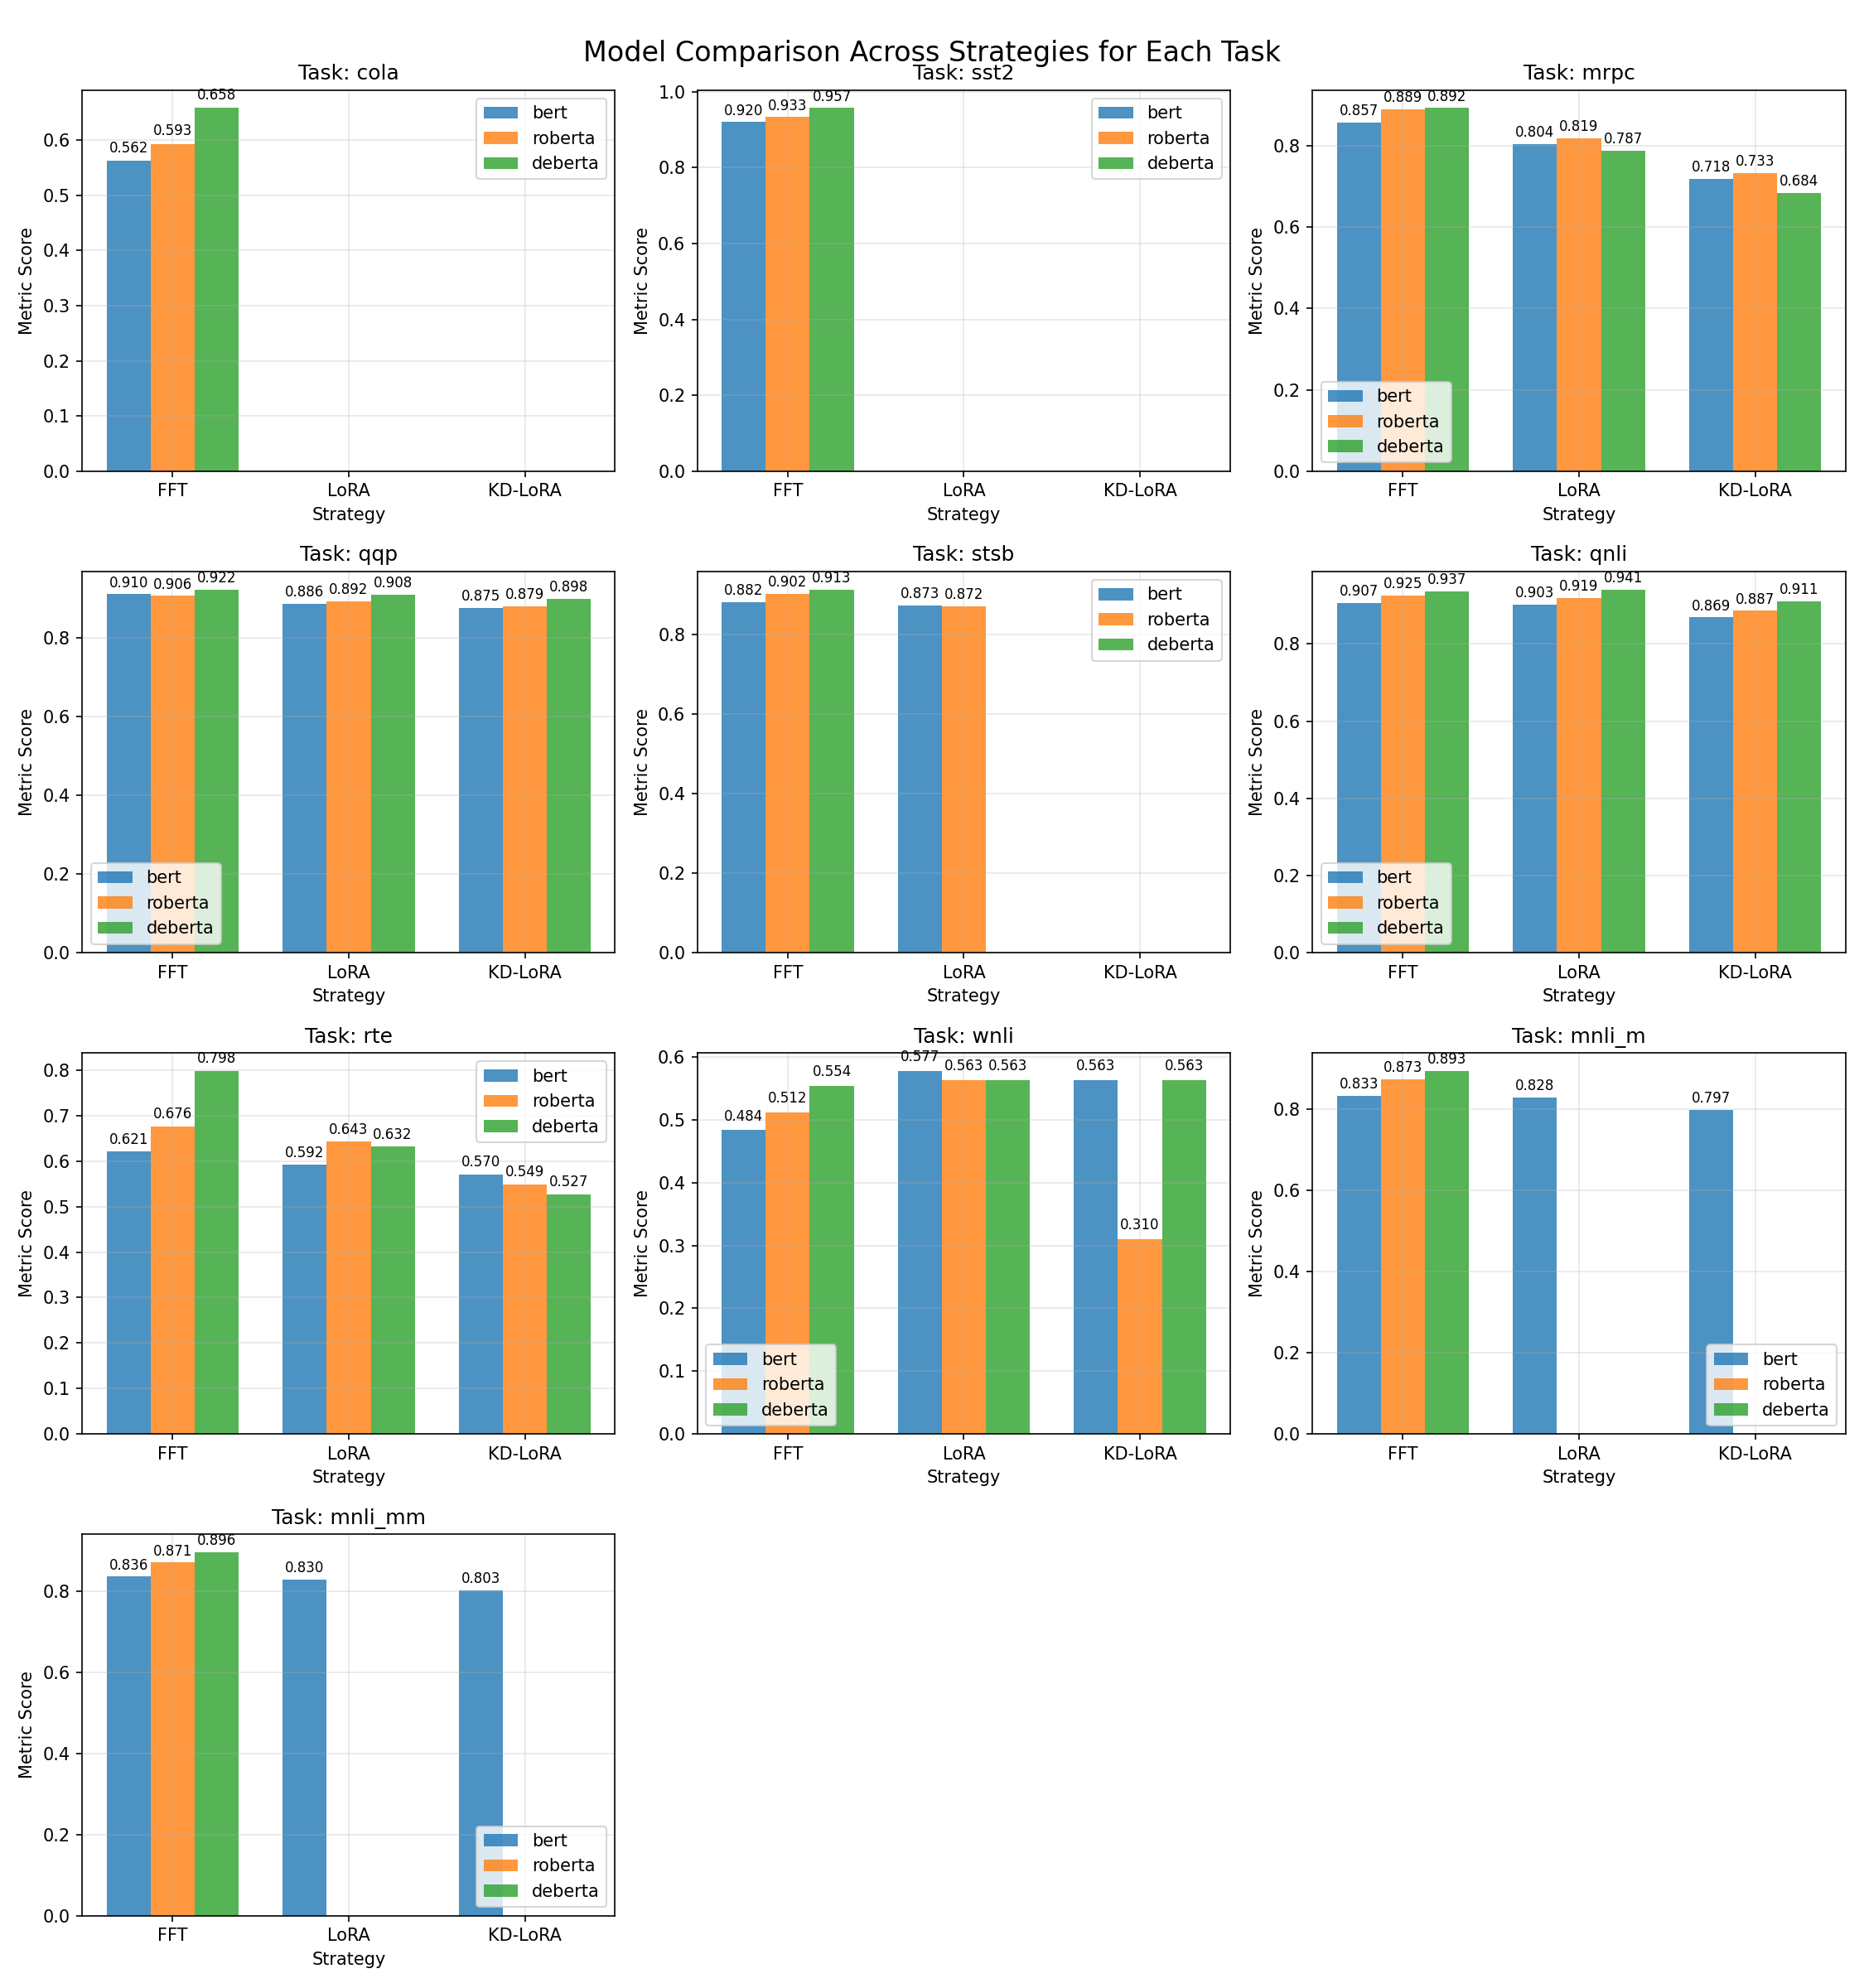

  - performance_delta.png


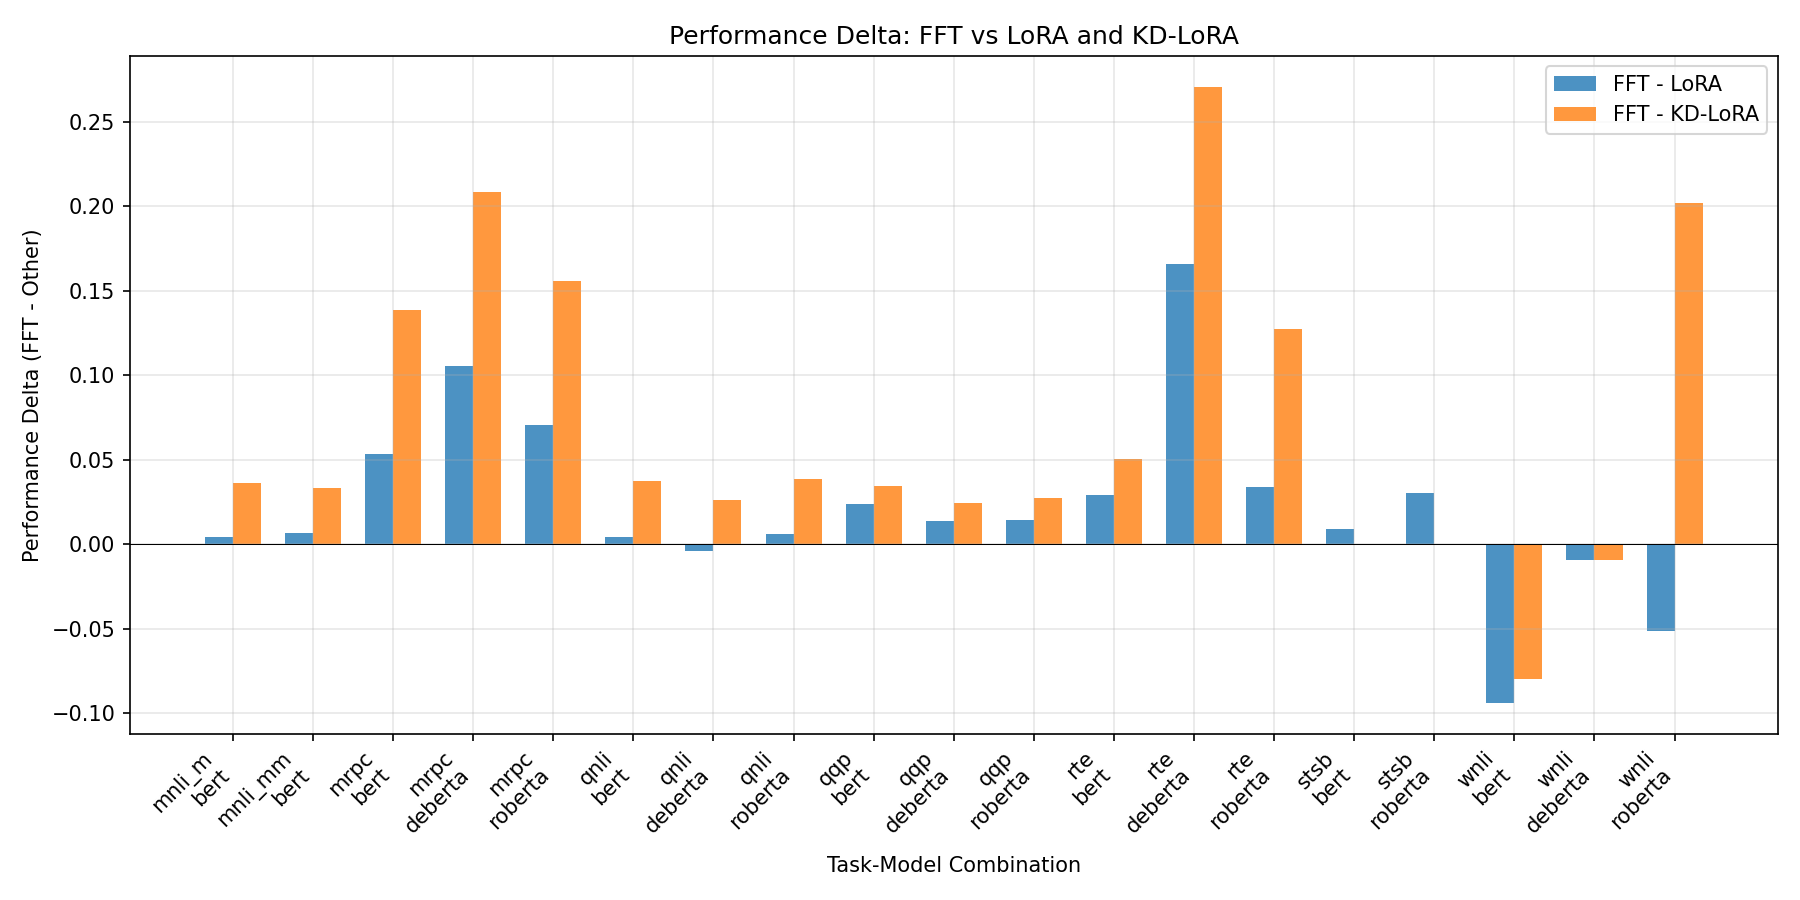

  - average_performance.png


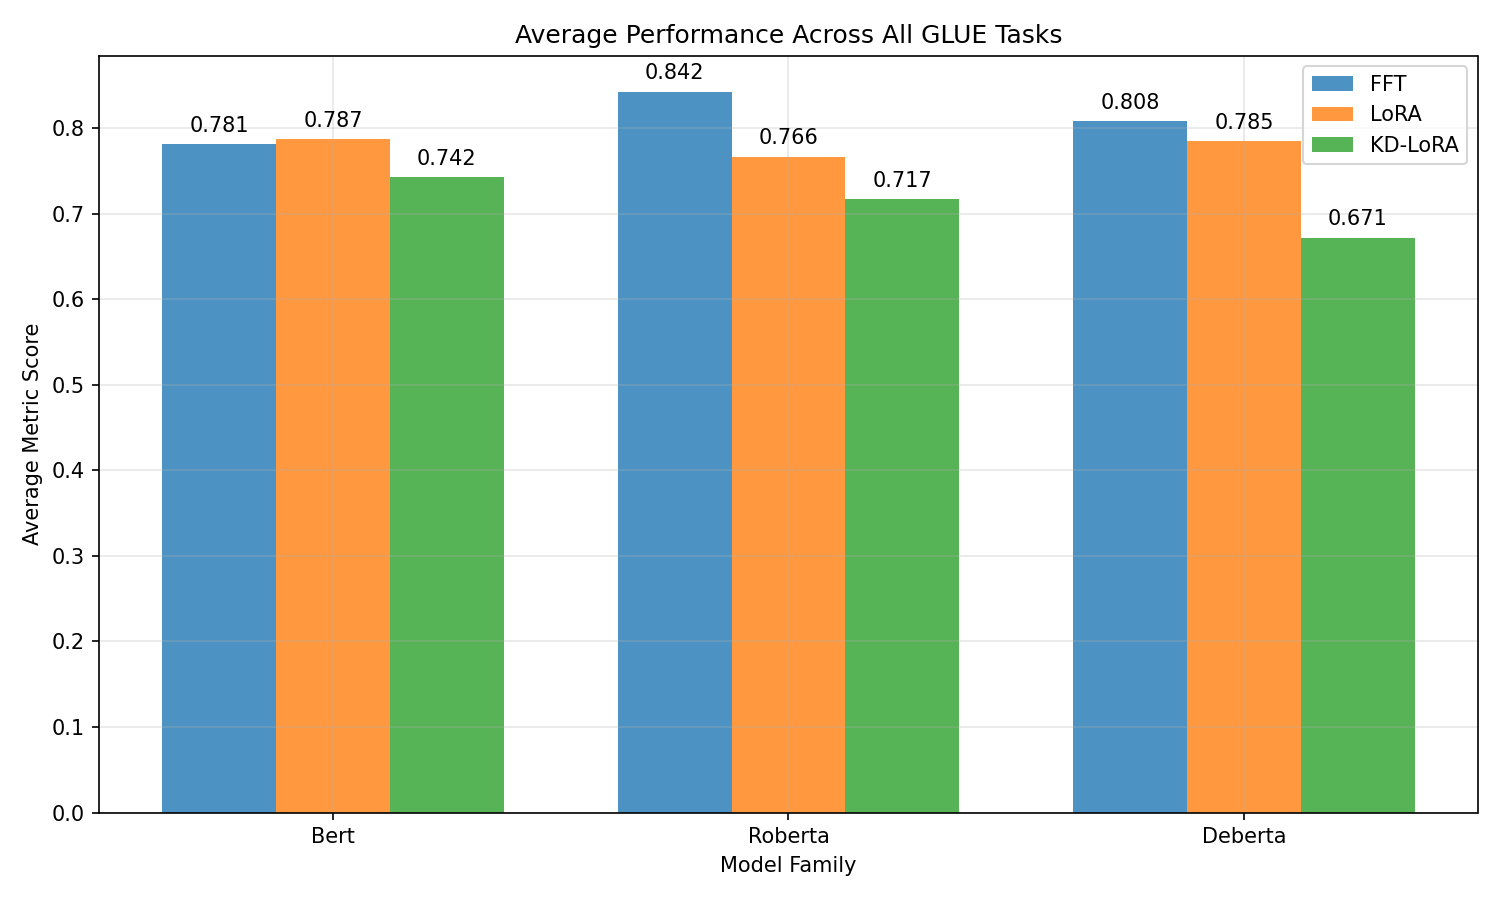

In [7]:
# Import visualization functions from our module
import sys
sys.path.append('.')
try:
    from visualize_results import generate_all_visualizations
    print("Visualization module imported successfully.")
    
    # Generate all visualizations
    generate_all_visualizations(table_df)
    
    # Display the generated images
    from IPython.display import Image, display
    print("\nGenerated visualizations:")
    
    viz_files = [
        'table_i_heatmap.png',
        'strategy_comparison_by_model.png',
        'model_comparison_by_task.png',
        'performance_delta.png',
        'average_performance.png'
    ]
    
    for viz_file in viz_files:
        if Path(viz_file).exists():
            print(f"  - {viz_file}")
            display(Image(filename=viz_file))
        else:
            print(f"  - {viz_file} (not found)")
            
except ImportError as e:
    print(f"Could not import visualization module: {e}")
    print("Please ensure visualize_results.py is in the current directory.")
except Exception as e:
    print(f"Error generating visualizations: {e}")


## 8. Data Availability Report

Analyze which combinations have data available.

In [8]:
if not table_df.empty:
    total_cells = len(table_df.index) * len(table_df.columns)
    missing_cells = table_df.isna().sum().sum()
    available_cells = total_cells - missing_cells
    
    print("DATA AVAILABILITY SUMMARY")
    print("-" * 40)
    print(f"Total cells in table: {total_cells}")
    print(f"Available cells: {available_cells} ({available_cells/total_cells*100:.1f}%)")
    print(f"Missing cells: {missing_cells} ({missing_cells/total_cells*100:.1f}%)")
    
    # Print missing combinations
    if missing_cells > 0:
        print("\nMissing combinations:")
        missing_count = 0
        for task in table_df.index:
            for model in MODEL_FAMILIES:
                for strategy in STRATEGIES:
                    if pd.isna(table_df.loc[task, (model, strategy)]):
                        missing_count += 1
                        if missing_count <= 20:  # Limit output
                            print(f"  {task} - {model} - {strategy}")
        if missing_count > 20:
            print(f"  ... and {missing_count - 20} more")
else:
    print("No data available for analysis.")


DATA AVAILABILITY SUMMARY
----------------------------------------
Total cells in table: 99
Available cells: 75 (75.8%)
Missing cells: 24 (24.2%)

Missing combinations:
  cola - bert - LoRA
  cola - bert - KD-LoRA
  cola - roberta - LoRA
  cola - roberta - KD-LoRA
  cola - deberta - LoRA
  cola - deberta - KD-LoRA
  sst2 - bert - LoRA
  sst2 - bert - KD-LoRA
  sst2 - roberta - LoRA
  sst2 - roberta - KD-LoRA
  sst2 - deberta - LoRA
  sst2 - deberta - KD-LoRA
  stsb - bert - KD-LoRA
  stsb - roberta - KD-LoRA
  stsb - deberta - LoRA
  stsb - deberta - KD-LoRA
  mnli_m - roberta - LoRA
  mnli_m - roberta - KD-LoRA
  mnli_m - deberta - LoRA
  mnli_m - deberta - KD-LoRA
  ... and 4 more


## 9. Discussion and Next Steps

### Key Observations:
1. **Data Availability**: The table shows available results for MrLoRA across GLUE tasks. Some combinations are missing (e.g., LoRA/KD-LoRA for CoLA, SST-2) as experiments are still ongoing.

2. **Performance Patterns**: 
   - FFT (full fine-tuning) generally achieves the highest performance
   - LoRA with MrLoRA shows competitive performance with significantly fewer parameters
   - KD-LoRA with MrLoRA shows the trade-off between performance and model size

3. **Model Differences**:
   - DeBERTa-v3 generally performs best across tasks
   - BERT shows competitive results with fewer parameters
   - RoBERTa falls between BERT and DeBERTa

### Next Steps:
1. Run missing experiments to complete Table I
2. Analyze parameter efficiency (trainable parameters vs performance)
3. Compare MrLoRA with other PEFT variants (OLoRA, DoRA, etc.)
4. Conduct statistical significance tests

### Notes:
- For MNLI, both matched (mnli_m) and mismatched (mnli_mm) accuracies are reported separately
- Metric varies by task: accuracy for most, Matthews correlation for CoLA, Pearson correlation for STS-B
- NaN values indicate missing experimental results


## 10. Export Analysis

Export the analysis for reporting.

In [9]:
# Create a summary report
report_lines = []
report_lines.append("KD-LoRA Experimental Results Analysis Report")
report_lines.append("=" * 60)
report_lines.append(f"Generated: {pd.Timestamp.now()}")
report_lines.append(f"Total data records: {len(raw_df)}")
report_lines.append(f"Table dimensions: {table_df.shape}")

if not table_df.empty:
    # Calculate some statistics
    report_lines.append("\nPerformance Statistics:")
    for model in MODEL_FAMILIES:
        for strategy in STRATEGIES:
            if (model, strategy) in table_df.columns:
                values = table_df[(model, strategy)].dropna()
                if len(values) > 0:
                    avg = values.mean()
                    report_lines.append(f"  {model}-{strategy}: {avg:.4f} (n={len(values)} tasks)")

# Write report
report_path = 'analysis_report.txt'
with open(report_path, 'w') as f:
    f.write('\n'.join(report_lines))

print(f"Analysis report saved to {report_path}")
print("\nFiles generated:")
for file in ['table_i_results.csv', 'table_i_latex.tex', 'analysis_report.txt']:
    if Path(file).exists():
        print(f"  - {file}")


Analysis report saved to analysis_report.txt

Files generated:
  - table_i_results.csv
  - table_i_latex.tex
  - analysis_report.txt
